<a href="https://colab.research.google.com/github/eunhyechoe/psyc60/blob/main/2_ISC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2. Intersubject Correlation (ISC) Analysis**


*Lastly Updated: Oct 15 (04:05 PM)*

#### 1. Setup environment, import libraries, and load searchlight indices

As mentioned in the previous tutorial, Colab refreshes its environment each time, so we need to prepare for data analysis again. Just like last time, let’s install several packages, including `neuroboros`, and load the necessary libraries and searchlight indices.

In [1]:
# cell 1
# start and install neuroboros
%%capture
%pip install -U neuroboros hyperalignment

In [2]:
# cell 2
# import libraries
import numpy as np
import neuroboros as nb
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [3]:
# cell 3
# load searchlight indices for ico8 right hemisphere (607 searchlights, 9666 vertices)
## rh, radii = 10 mm, 15, and 20 mm
SLS_ico8_10mm_rh = nb.sls('r', 10, space='onavg-ico32', center_space='onavg-ico8', return_dists=False)
SLS_ico8_15mm_rh = nb.sls('r', 15, space='onavg-ico32', center_space='onavg-ico8', return_dists=False)
SLS_ico8_20mm_rh, Dists_ico8_20mm_rh = nb.sls('r', 20, space='onavg-ico32', center_space='onavg-ico8', return_dists=True)
# sls function input variables: ('hemisphere', radius, vertex space, center space, option to load file of distances from center to each vertex)

### 2. Load a multi-subject dataset

In this tutorial, we will perform an intersubject correlation analysis using data from multiple participants. As we practiced last time, let's use the `forrest` dataset provided by `neuroboros` to load a multiple-subject dataset.

In [4]:
# define data first
dset = nb.Forrest()
sids = dset.subjects

In [5]:
sids

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '09',
 '10',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20']

In [6]:
# Part II, ISC, cell 1
# upload multisubject data (five brains, right hemisphere for first run)
# dm5 is a data matrix with brains, timepoints, and vertices as dimensions [5,451,9666]
#dm5 = np.zeros((5,451,9666))
#for subj in range(5):
#  sid = sids[subj]
#  dm5[subj,:,:] = dset.get_data(sid, 'forrest', 1, 'r')
# (subject id, 'dataset', run, 'hemisphere')

 Since loading the entire dataset (i.e. `for subj in range(20)`) would take too much time, we will practice using data from just three participants.

In [7]:
dm = np.zeros((3,451,9666))
for subj in range(3):
 sid = sids[subj]
 dm[subj,:,:] = dset.get_data(sid, 'forrest', 1, 'r')

### 3. Calculate ISC for all vertices, all individual pairs


#### (1) Load dataset

In [8]:
dm.shape

(3, 451, 9666)



The multisubject data matrix we've loaded has a structure of `[subject, timepoint, vertices]`. We will calculate the intersubject correlation coefficient for each of the 9666 vertices that make up the data points of the right hemisphere. Let's see if we can observe significant intersubject correlation for specific vertex across time.

Since we need to repeat the calculation for all vertices, we will use a `for vertex in range(9666)` loop.

In [48]:
# Part II, ISC, cell 2 copy
# calculate ISC pairwise
ISCs = np.zeros((3,3,9666))
for vtx in range(9666):
  ISCs[:, :, vtx] = np.corrcoef(dm[:, :, vtx])
  ISCs_clean = ISCs # copy ISCs to make a clean version
  ISCs_clean[np.isnan(ISCs)] = 0 # clean up not-a-number cells

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Therefore, each vertex will have 3x3 correlation matrix for three participants.

In [25]:
ISCs_clean.shape

(3, 3, 9666)

#### (2) Calculate mean ISC across pairs
Now, let's calculate mean of intersubject correlation, across all possible pairs (of subjects). Since you have a 3x3 matrix for each vertex, you need to exclude the 3 diagonal elements (self-correlations) and calculate the average of the 6 off-diagonal elements (pairwise correlations between the 3 subjects).

In [49]:
# Part II, ISC, cell 2
## calculate mean ISCs to show brain map
ISCs_mean = (np.sum(ISCs_clean, axis = (0,1))-3)/6
print("max ISC =", np.max(ISCs_mean))

max ISC = 0.6529441046341343


#### (3) Plot brain image of ISCs
You can plot ISCs as brain images. Don't forget to set the maximum ISC value as the plot's maximum value.

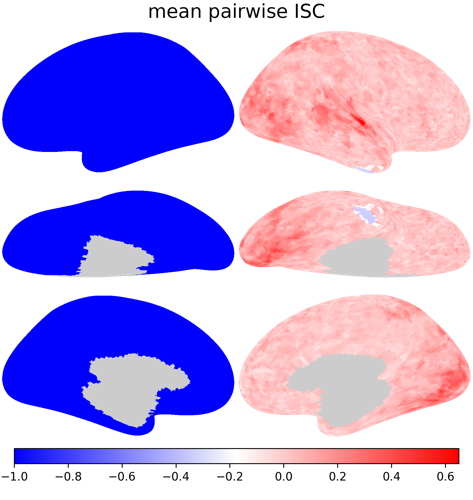

In [12]:
# Part II, ISC, cell 3
## plot mean pairwise ISCs
lh_minus_one = np.zeros((9675))-1
nb.plot([lh_minus_one, ISCs_mean], cmap='bwr', vmax=0.65, vmin=-1, title='mean pairwise ISC')


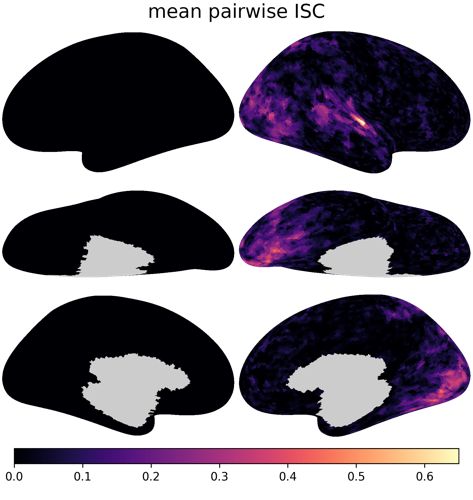

In [13]:
# plot positive values only
lh_zero = np.zeros((9675))
nb.plot([lh_zero, ISCs_mean], cmap='magma', vmax=np.max(ISCs_mean), vmin=0, title='mean pairwise ISC')

In [14]:
# # Part II, ISC, cell 2 alternate
# # calculate ISC pairwise
# ISCs = np.zeros[5,5,9666]
# for subj in range(5):
#   for subj in range(5):
#     for vtx in range(9666):
#       ISCs[subj1, subj2, vtx] = np.corrcoef(dm5[subj1, :, vtx], dm5[subj2, :, vtx])[0,1]

### 4. Calculate ISCs for searchlight, all individual pairs

Let's calculate the intersubject correlation (ISC) for each searchlight, focusing on the brain activity of the vertices within each searchlight across time, rather than individual vertices across time. For this exercise, we will use ico8 searchlights with a radius of 15mm. The ico8 space provides a total of 607 searchlights.

In [15]:
len(SLS_ico8_15mm_rh)

607

#### (1) Calculate searchlight means
However, before calculating ISC, we first need to compute the average activities of all vertices within each searchlight for each timeseries, as we focus on searchlights rather than individual vertices. `sl_means` will have the structure `[subject, timeseries, searchlight]`.

In [50]:
# Part II, ISCs, calculate ISCs of searchlight time-series
## calculate sl means
sl_means = np.zeros((3,451,len(SLS_ico8_15mm_rh)))
for sl in range(len(SLS_ico8_15mm_rh)):
  sl_means[:,:,sl] = np.mean(dm[:,:,SLS_ico8_15mm_rh[sl]], axis = 2)

In [17]:
sl_means.shape

(3, 451, 607)

#### (2) Calculate ISCs
Let's see if the brain activity within each searchlight correlates across time.

In [51]:
# calculate coarse ISCs
ISCs_ico8 = np.zeros((3,3,607))
for sl in range(607):
  ISCs_ico8[:, :, sl] = np.corrcoef(sl_means[:, :, sl])
  ISCs_ico8_clean = ISCs_ico8
  ISCs_ico8_clean[np.isnan(ISCs_ico8)] = 0

In [52]:
# Part II, ISC, cell 2
## calculate mean searchlight ISCs to show brain map
ISCs_mean_ico8 = (np.sum(ISCs_ico8_clean, axis = (0,1))-3)/6
print("max ISC =", np.max(ISCs_mean_ico8))

max ISC = 0.5857528193462688


#### (3) Plot brain image of ISCs

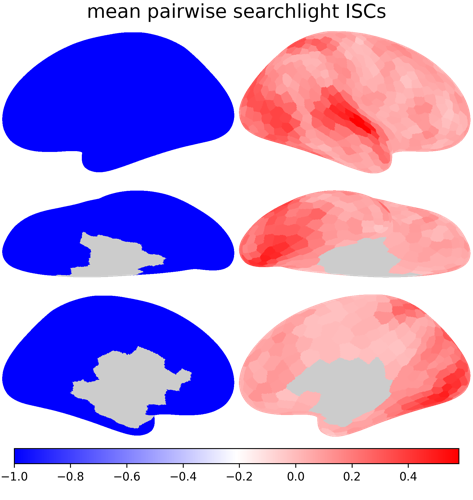

In [27]:
## plot mean pairwise ISCs
lh8_minus_one = np.zeros((603))-1
nb.plot([lh8_minus_one, ISCs_mean_ico8], cmap='bwr', vmax=0.58, vmin=-1, title='mean pairwise searchlight ISCs')


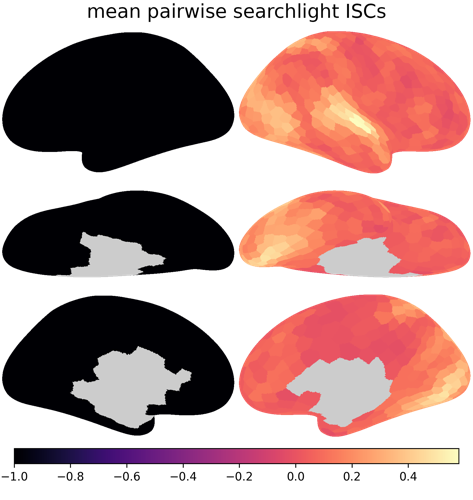

In [28]:
lh8_zero = np.zeros((603))-1
nb.plot([lh8_zero, ISCs_mean_ico8], cmap='magma', vmax=0.58, vmin=-1, title='mean pairwise searchlight ISCs')

### 5. Compare multisubject dataset

#### (1) Compare brain activity between subjects across timeseries

Text(0.5, 1.0, 'TTT')

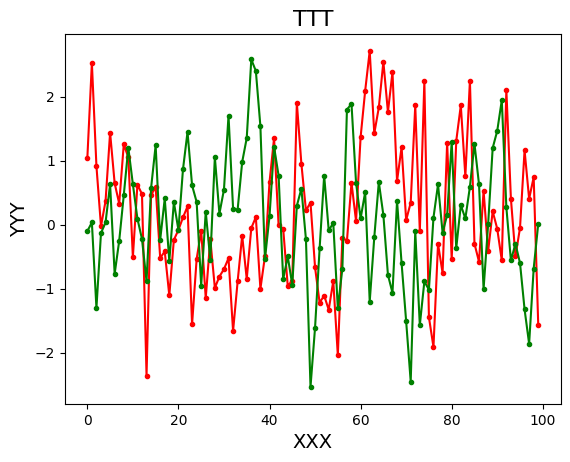

In [22]:
# Part II, ISC, cell 3 & 4
## plot line graph of two vertex time-series from different brains
## FFA center vertex is 6579 in ico32 and 262 in ico8
b1 = 0
b2 = 1
time_series1 = dm[b1,100:200,6579]
time_series2 = dm[b2,100:200,6579]
plt.plot(time_series1, "r.-")
plt.plot(time_series2, "g.-")
plt.xlabel("XXX", fontsize=14)
plt.ylabel("YYY", fontsize =14)
plt.title("TTT", fontsize=16)

#### (2) Compare brain activity within searchlight between subjects

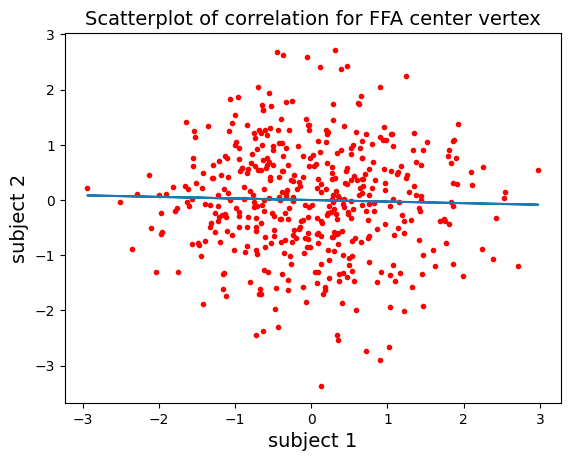

In [23]:
# cell 5
## plot scatter plot for ISC for one vertex with regression line
plt.plot(dm[b1,:,6579], dm[b2,:,6579], 'r.')  # make scatterplot
m, b = np.polyfit(dm[b1,:,6579], dm[b2,:,6579], 1)  # calculate linear regression
plt.plot(dm[b1,:,6579], m*dm[b1,:,6579] + b)  # plot regression line
plt.xlabel("subject 1", fontsize=14)
plt.ylabel("subject 2", fontsize =14)
plt.title("Scatterplot of correlation for FFA center vertex", fontsize=14)
plt.show()


In [24]:
ISCs_mean[262] # should be ico8 vertice

0.2151494342564746

### 💡 Tip for Assignment 2's Challenge

One of the methods for calculating ISC that we covered in this tutorial involves calculating the correlation for all possible participant pairs and then averaging the results. *However*, there is another approach, where you calculate **the correlation between each participant and the mean of all other participants excluding that individual.**

In the challenge section of Assignment 2, you are asked to compare the ISC results using this method with the two methods you just practiced in this tutorial: (1) ISCs using individual pairs (2) ISCs using searchlight means

### 6. Calculate ISCs for all vertices, individuals vs others means

First, we will calculate the correlation of each individual subject's data with the mean of all other participants' data across time for all vertices. Since `dm` has the structure `[subj, timeseries, vertex]`, the data for a specific participant and vertex can be accessed using `dm[subj, :, vtx]`.

#### (1) Generate the means of others
Now, let's create `dm_others`, which will store the mean of others' data.

In [53]:
dm_others = np.zeros((3,451,9666))

for subj in range(3):
  dm_others[subj,:,:] = (np.sum(dm, axis=0) - dm[subj,:,:])/2

This will be compared with the same statistical method we used to calculate ISCs for all individual pairs.

In [ ]:
# calculate ISCs between individual vs others mean,
# for all vertices across time
ISCs_2 = np.zeros((3,9666))

for subj in range(3):
  for vtx in range(9666):
    ISCs_2[subj, vtx] = np.corrcoef(dm[subj, :, vtx], dm_others[subj, :, vtx])[0,1]
    ISCs_2_clean = ISCs_2
    ISCs_2_clean[np.isnan(ISCs_2)] = 0

#### (2) Calculate mean ISCs across pairs

In [54]:
# calculate means of ISCs across the pairs (individuals vs others mean) for all vertices
ISCs_mean_2 = np.mean(ISCs_2_clean, axis = 0)
print("max ISC ind with other's mean =", np.max(ISCs_mean_2))

max ISC ind with other's mean = 0.7185225649703808


#### (3) Plot brain image of ISCs

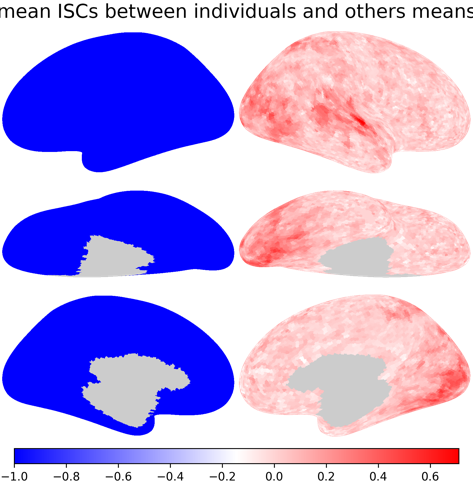

In [44]:
# plot with the same method
nb.plot([lh_minus_one, ISCs_mean_2], cmap='bwr', vmax=0.71, vmin=-1, title='mean ISCs between individuals and others means')

### 7. Calculate differences between ISCs

#### (1) All individual pairs - Individual vs others mean pairs

As ISCs between all individual pairs have the same resolution as the ISCs between individuals and the mean of others, we can simply subtract one from the other like this:

In [87]:
print(ISCs_mean.shape, ISCs_mean_2.shape)

(9666,) (9666,)


In [90]:
print(max(ISCs_mean_2-ISCs_mean))

0.3333333333333333


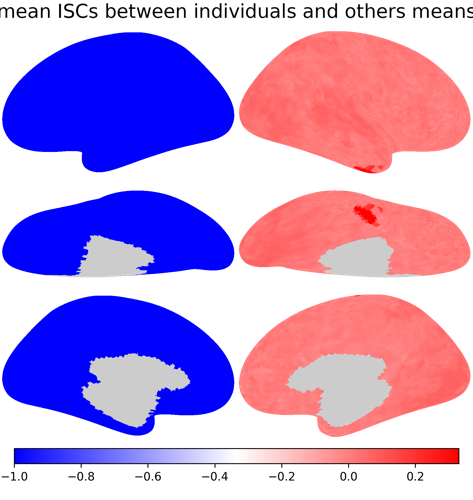

In [91]:
nb.plot([lh_minus_one, ISCs_mean_2-ISCs_mean], cmap='bwr', vmax=0.33, vmin=-1, title='mean ISCs between individuals and others means')

#### (2) All vertices - Searchlight

The searchlight analysis, with ico8 resolution, consists of 607 data points. To compare high-resolution data with this, we need to select the vertices corresponding to the centers of the 607 searchlights from the 9666 data points.

In [92]:
print(ISCs_mean.shape, ISCs_mean_ico8.shape)

(9666,) (607,)


`SLS_ico8_15mm_rh` contains all the vertices within each searchlight. For each searchlight, the index [0] represents the vertex that is located at the center of the searchlight. We can save the vertex of each searchlight's center to `hires_centers`

In [94]:
len(SLS_ico8_15mm_rh)

607

In [64]:
hires_centers = np.zeros(607)
for sl in range(607):
  hires_centers[sl] = SLS_ico8_15mm_rh[sl][0]

Now, using the vertex corresponding to each searchlight center `np.int_(hires_centers[sl])`, we can store a subset of the data from `ISCs_mean` into `ISCs_hi_to_lo` for the 607 data points.


In [84]:
ISCs_hi_to_lo = np.zeros(607)

for sl in range(607):
  ISCs_hi_to_lo[sl] = ISCs_mean[np.int_(hires_centers[sl])]
  #ISCs_clean[:,:,hires_centers[sl]]

As a result, `ISCs_hi_to_lo` will have the same resolution as `ISCs_mean_ico8`, allowing for easy comparison and plotting through a simple subtraction.

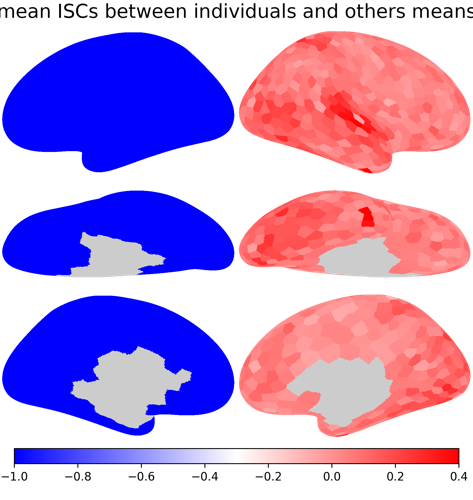

In [86]:
nb.plot([lh8_minus_one, ISCs_mean_ico8-ISCs_hi_to_lo], cmap='bwr', vmax=0.4, vmin=-1, title='Difference between ISCs')